<a href="https://colab.research.google.com/github/jh-4166640/Machine-Learning-Lecture/blob/main/FinancePredictModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----
#주가 예측 텀프로젝트
-----

###Train / Test divied

In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data load
shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01') # 신풍제약의 작은 폭의 잦은 등락으로 상승 추세선의 2015 부근이라  2014-12부터 선택
robostar_finance = yf.download('090360.KQ', start='2013-09-01')        # 로보스타의 작은 하락 추세선을 학습에 사용하기 위함
daihan_pharm_finance = yf.download('023910.KQ', start='2010-09-01')    # 급등 전의 신호가 있는 위치가 2010-09
dbhitek_finance = yf.download('000990.KS', start='2009-05-01')         # 등락 변동성이 가장 큰 부분부터 시작하기 위함
skdnd_finance = yf.download('210980.KS', start='2016-05-01')           # 상장 후 안정기에 진입했을 때부터 학습

# train, test divied
shinpoong_train_idx = np.where('2025-10-20'>shinpoong_pharm_finance.index)
robostar_train_idx = np.where('2025-10-20'>robostar_finance.index)
daihan_train_idx = np.where('2025-10-20'>daihan_pharm_finance.index)
dbhitek_train_idx = np.where('2025-10-20'>dbhitek_finance.index)
skdnd_train_idx = np.where('2025-10-20'>skdnd_finance.index)

shinpoong_test_idx = np.where('2025-10-20'<=shinpoong_pharm_finance.index)
robostar_test_idx = np.where('2025-10-20'<=robostar_finance.index)
daihan_test_idx = np.where('2025-10-20'<=daihan_pharm_finance.index)
dbhitek_test_idx = np.where('2025-10-20'<=dbhitek_finance.index)
skdnd_test_idx = np.where('2025-10-20'<=skdnd_finance.index)

# shinpoong_train = shinpoong_pharm_finance.iloc[shinpoong_train_idx]
# robostar_train = robostar_finance.iloc[robostar_train_idx]
# daihan_train = daihan_pharm_finance.iloc[daihan_train_idx]
# dbhitek_train = dbhitek_finance.iloc[dbhitek_train_idx]
# skdnd_train = skdnd_finance.iloc[skdnd_train_idx]

# shinpoong_test = shinpoong_pharm_finance.iloc[shinpoong_test_idx]
# robostar_test = robostar_finance.iloc[robostar_test_idx]
# daihan_test = daihan_pharm_finance.iloc[daihan_test_idx]
# dbhitek_test = dbhitek_finance.iloc[dbhitek_test_idx]
# skdnd_test = skdnd_finance.iloc[skdnd_test_idx]

/tmp/ipython-input-1217943097.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  shinpoong_pharm_finance = yf.download('019170.KS', start='2014-12-01') # 신풍제약의 작은 폭의 잦은 등락으로 상승 추세선의 2015 부근이라  2014-12부터 선택
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1217943097.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar_finance = yf.download('090360.KQ', start='2013-09-01')        # 로보스타의 작은 하락 추세선을 학습에 사용하기 위함
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1217943097.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  daihan_pharm_finance = yf.download('023910.KQ', start='2010-09-01')    # 급등 전의 신호가 있는 위치가 2010-09
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1217943097.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dbh

###기술적 지표 추가

In [20]:

# NaN 제거 - GPT 활용
def clean_nan(data, method="drop"):
    """
    data: pandas DataFrame
    method: 'drop', 'bfill', 'ffill', 'bothfill'
    """
    if method == "drop":
        return data.dropna()

    elif method == "bfill":
        return data.fillna(method="bfill")

    elif method == "ffill":
        return data.fillna(method="ffill")

    elif method == "bothfill":
        return data.fillna(method="ffill").fillna(method="bfill")

    else:
        raise ValueError("method must be: 'drop', 'bfill', 'ffill', 'bothfill'")


# 단순 이동평균선 데이터 + 불린저 밴드 사용
def BollingerBand(data, window=20):
  # SMA20
  data[f'BB_MID_{window}'] = data['Close'].rolling(window=window).mean()
  # 표준편차
  data[f'BB_STD_{window}'] = data['Close'].rolling(window=window).std()
  # 상단 밴드
  data[f'BB_UPPER_{window}'] = data[f'BB_MID_{window}'] + (2 * data[f'BB_STD_{window}'])
  # 하단 밴드
  data[f'BB_LOWER_{window}'] = data[f'BB_MID_{window}'] - (2 * data[f'BB_STD_{window}'])

  return data

# EMA 지수 이동평균선 사용
def ExpMovingAverage(data, windows=[12, 30]):
  for w in windows:
    data[f'EMA{w}'] = data['Close'].ewm(span=w, adjust=False).mean()
  return data

def add_ticker_id(arr, id_num):
  id_col = np.full((arr.shape[0], 1), id_num)
  return np.hstack([arr, id_col])


sp1=BollingerBand(shinpoong_pharm_finance)
rbs1=BollingerBand(robostar_finance)
dh1=BollingerBand(daihan_pharm_finance)
dbh1=BollingerBand(dbhitek_finance)
skd1=BollingerBand(skdnd_finance)

sp2=ExpMovingAverage(sp1)
rbs2=ExpMovingAverage(rbs1)
dh2=ExpMovingAverage(dh1)
dbh2=ExpMovingAverage(dbh1)
skd2=ExpMovingAverage(skd1)

sp=clean_nan(sp2,"bothfill")
rbs=clean_nan(rbs2,"bothfill")
dh=clean_nan(dh2,"bothfill")
dbh=clean_nan(dbh2,"bothfill")
skd=clean_nan(skd2,"bothfill")

np_sp = sp.values
np_rbs = rbs.values
np_dh = dh.values
np_dbh = dbh.values
np_skd = skd.values



/tmp/ipython-input-2845825852.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return data.fillna(method="ffill").fillna(method="bfill")


In [34]:
def minmax_normalize_np(data, feature_idx=None, return_params=True):
    """
    data: 2D numpy array (행: 날짜, 열: feature)
    feature_idx: 정규화할 열 인덱스 리스트, None이면 전체 열
    return_params: True면 min/max 값도 반환
    """
    data_norm = data.copy()
    if feature_idx is None:
        feature_idx = np.arange(data.shape[1])

    min_vals = {}
    max_vals = {}

    for idx in feature_idx:
        col = data[:, idx]
        min_val = col.min()
        max_val = col.max()
        min_vals[idx] = min_val
        max_vals[idx] = max_val

        if max_val - min_val == 0:
            data_norm[:, idx] = 0.0
        else:
            data_norm[:, idx] = (col - min_val) / (max_val - min_val)

    if return_params:
        return data_norm, min_vals, max_vals
    else:
        return data_norm


np_sp_norm, sp_min, sp_max = minmax_normalize_np(np_sp)
np_rbs_norm, rbs_min, rbs_max = minmax_normalize_np(np_rbs)
np_dh_nor, dh_min, dh_max = minmax_normalize_np(np_dh)
np_dbh_norm, dbh_min, dbh_max = minmax_normalize_np(np_dbh)
np_skd_norm, skd_min, skd_max = minmax_normalize_np(np_skd)

# train set divide
# 신풍제약
np_sp_train_norm = np_sp_norm[shinpoong_train_idx,:]
np_sp_train_norm = np_sp_train_norm.reshape(-1,np_sp_train_norm.shape[2])
# 로보스타
np_rbs_train_norm = np_rbs_norm[robostar_train_idx,:]
np_rbs_train_norm = np_rbs_train_norm.reshape(-1,np_rbs_train_norm.shape[2])
# 대한약품
np_dh_train_norm = np_dh_norm[daihan_train_idx,:]
np_dh_train_norm = np_dh_train_norm.reshape(-1,np_dh_train_norm.shape[2])
# DB하이텍
np_dbh_train_norm = np_dbh_norm[dbhitek_train_idx,:]
np_dbh_train_norm = np_dbh_train_norm.reshape(-1,np_dbh_train_norm.shape[2])
# SK D&D
np_skd_train_norm = np_skd_norm[skdnd_train_idx,:]
np_skd_train_norm = np_skd_train_norm.reshape(-1,np_skd_train_norm.shape[2])

# test set divide
# 신풍제약
np_sp_test_norm = np_sp_norm[shinpoong_test_idx,:]
np_sp_test_norm = np_sp_test_norm.reshape(-1,np_sp_test_norm.shape[2])
# 로보스타
np_rbs_test_norm = np_rbs_norm[robostar_test_idx,:]
np_rbs_test_norm = np_rbs_test_norm.reshape(-1,np_rbs_test_norm.shape[2])
# 대한약품
np_dh_test_norm = np_dh_norm[daihan_test_idx,:]
np_dh_test_norm = np_dh_test_norm.reshape(-1,np_dh_test_norm.shape[2])
# DB하이텍
np_dbh_test_norm = np_dbh_norm[dbhitek_test_idx,:]
np_dbh_test_norm = np_dbh_test_norm.reshape(-1,np_dbh_test_norm.shape[2])
# SK D&D
np_skd_test_norm = np_skd_norm[skdnd_test_idx,:]
np_skd_test_norm = np_skd_test_norm.reshape(-1,np_skd_test_norm.shape[2])

print(f"All {np_sp_norm.shape}, train {np_sp_train_norm.shape}, test {np_sp_test_norm.shape}")
print(f"All {np_rbs_norm.shape}, train {np_rbs_train_norm.shape}, test {np_rbs_test_norm.shape}")
print(f"All {np_dh_norm.shape}, train {np_dh_train_norm.shape}, test {np_dh_test_norm.shape}")
print(f"All {np_dbh_norm.shape}, train {np_dbh_train_norm.shape}, test {np_dbh_test_norm.shape}")
print(f"All {np_skd_norm.shape}, train {np_skd_train_norm.shape}, test {np_skd_test_norm.shape}")


# # 정규화 해서 list에 저장
np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
np_test_list_norm = [np_sp_test_norm, np_rbs_test_norm, np_dh_test_norm, np_dbh_test_norm, np_skd_test_norm]



All (2699, 11), train (2666, 11), test (33, 11)
All (2997, 11), train (2964, 11), test (33, 11)
All (3735, 11), train (3702, 11), test (33, 11)
All (4087, 11), train (4054, 11), test (33, 11)
All (2349, 11), train (2316, 11), test (33, 11)


##모델 정의

In [22]:
import keras
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout,Input,ELU
from keras.models import Model
from keras.optimizers import Adam

feature_n = np_sp_train_norm.shape[1]
output_n = 4
lookback = 5 # 3~20 사이 값
dropout_rate = 0.2

input_layer = Input(shape=(lookback, feature_n))
x = Conv1D(filters=64, kernel_size=3,strides=1,padding="same")(input_layer)
x = ELU(alpha=1.0)(x)
x = Conv1D(filters=128, kernel_size=3,strides=1,padding="same")(x)
x = ELU(alpha=1.0)(x)
x = MaxPooling1D(pool_size=2)(x)
x = LSTM(128, activation='tanh',return_sequences=True)(x)
x = Dropout(rate = dropout_rate)(x)
# x = LSTM(128, activation='tanh',return_sequences=True)(x)
# x = Dropout(rate = dropout_rate)(x)
x = LSTM(64, activation='tanh',return_sequences=False)(x)
x = Dropout(rate = dropout_rate)(x)
output_layer = Dense(output_n)(x)

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(
    learning_rate=0.0005,
    beta_1=0.85,
    beta_2=0.999,
    epsilon=1e-7
)
model.compile(
    optimizer='adam',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanSquaredError()]
)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 11)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 5, 64)          │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_4 (ELU)                     │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_5 (ELU)                     │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 2, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,132 (813.02 KB)

 Trainable params: 208,132 (813.02 KB)

 Non-trainable params: 0 (0.00 B)

##Model 학습

In [50]:
# 현재는 종목별 특징을 고려 안함
# 종목별 특징을 사용하고 싶으면 종목 ticker 열을 추가해서 학습

epoch = 300
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,        # validation_loss 기준 최적 모델만 저장
    monitor="val_loss",
    mode="min"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,               # 30 Epoch 동안 개선 없으면 종료
    restore_best_weights=True  # 종료 시 최적 가중치 복원
)

# np_train_list_norm = [np_sp_train_norm, np_rbs_train_norm, np_dh_train_norm, np_dbh_train_norm, np_skd_train_norm]
x_train, t_train = [], []
for data in np_train_list_norm:
    # 이미 정규화, NaN 처리 완료된 상태
    for idx in range(data.shape[0] - lookback):
        x_train.append(data[idx:idx+lookback])
        t_train.append(data[idx+lookback,0:4])  # 예: Close,
x_train=np.array(x_train)
t_train=np.array(t_train)

history = model.fit(x_train,t_train,epochs=epoch,batch_size=32,callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1877e-04 - mean_squared_error: 5.1877e-04

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1865e-04 - mean_squared_error: 5.1865e-04
Epoch 2/300
 17/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2031e-04 - mean_squared_error: 4.2031e-04

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  current = self.get_monitor_value(logs)


490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5916e-04 - mean_squared_error: 4.5916e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5923e-04 - mean_squared_error: 4.5923e-04
Epoch 3/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0322e-04 - mean_squared_error: 5.0322e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.0329e-04 - mean_squared_error: 5.0329e-04
Epoch 4/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1258e-04 - mean_squared_error: 5.1258e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1237e-04 - mean_squared_error: 5.1237e-04
Epoch 5/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1570e-04 - mean_squared_error: 5.1570e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1565e-04 - mean_squared_error: 5.1565e-04
Epoch 6/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3628e-04 - mean_squared_error: 5.3628e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.3533e-04 - mean_squared_error: 5.3533e-04
Epoch 7/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9547e-04 - mean_squared_error: 4.9547e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9542e-04 - mean_squared_error: 4.9542e-04
Epoch 8/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6457e-04 - mean_squared_error: 5.6457e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.6436e-04 - mean_squared_error: 5.6436e-04
Epoch 9/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6903e-04 - mean_squared_error: 4.6903e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6917e-04 - mean_squared_error: 4.6917e-04
Epoch 10/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9100e-04 - mean_squared_error: 4.9100e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9094e-04 - mean_squared_error: 4.9094e-04
Epoch 11/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1399e-04 - mean_squared_error: 5.1399e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1392e-04 - mean_squared_error: 5.1392e-04
Epoch 12/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5952e-04 - mean_squared_error: 4.5952e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5977e-04 - mean_squared_error: 4.5977e-04
Epoch 13/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7325e-04 - mean_squared_error: 4.7325e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7329e-04 - mean_squared_error: 4.7329e-04
Epoch 14/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9997e-04 - mean_squared_error: 4.9997e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9982e-04 - mean_squared_error: 4.9982e-04
Epoch 15/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9007e-04 - mean_squared_error: 4.9007e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9005e-04 - mean_squared_error: 4.9005e-04
Epoch 16/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8057e-04 - mean_squared_error: 4.8057e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8060e-04 - mean_squared_error: 4.8060e-04
Epoch 17/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8713e-04 - mean_squared_error: 4.8713e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8711e-04 - mean_squared_error: 4.8711e-04
Epoch 18/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1494e-04 - mean_squared_error: 5.1494e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.1472e-04 - mean_squared_error: 5.1472e-04
Epoch 19/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4902e-04 - mean_squared_error: 4.4902e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4918e-04 - mean_squared_error: 4.4918e-04
Epoch 20/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2522e-04 - mean_squared_error: 5.2522e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.2502e-04 - mean_squared_error: 5.2502e-04
Epoch 21/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5648e-04 - mean_squared_error: 4.5648e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5652e-04 - mean_squared_error: 4.5652e-04
Epoch 22/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6269e-04 - mean_squared_error: 4.6269e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6274e-04 - mean_squared_error: 4.6274e-04
Epoch 23/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7237e-04 - mean_squared_error: 4.7237e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7250e-04 - mean_squared_error: 4.7250e-04
Epoch 24/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5833e-04 - mean_squared_error: 4.5833e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5839e-04 - mean_squared_error: 4.5839e-04
Epoch 25/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6805e-04 - mean_squared_error: 4.6805e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6807e-04 - mean_squared_error: 4.6807e-04
Epoch 26/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5112e-04 - mean_squared_error: 4.5112e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5119e-04 - mean_squared_error: 4.5119e-04
Epoch 27/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5444e-04 - mean_squared_error: 4.5444e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5449e-04 - mean_squared_error: 4.5449e-04
Epoch 28/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9046e-04 - mean_squared_error: 4.9046e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9041e-04 - mean_squared_error: 4.9041e-04
Epoch 29/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8120e-04 - mean_squared_error: 4.8120e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8117e-04 - mean_squared_error: 4.8117e-04
Epoch 30/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7271e-04 - mean_squared_error: 4.7271e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7273e-04 - mean_squared_error: 4.7273e-04
Epoch 31/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8680e-04 - mean_squared_error: 4.8680e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8676e-04 - mean_squared_error: 4.8676e-04
Epoch 32/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3741e-04 - mean_squared_error: 4.3741e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3757e-04 - mean_squared_error: 4.3757e-04
Epoch 33/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6089e-04 - mean_squared_error: 4.6089e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6096e-04 - mean_squared_error: 4.6096e-04
Epoch 34/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6038e-04 - mean_squared_error: 4.6038e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6043e-04 - mean_squared_error: 4.6043e-04
Epoch 35/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6290e-04 - mean_squared_error: 4.6290e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6305e-04 - mean_squared_error: 4.6305e-04
Epoch 36/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8634e-04 - mean_squared_error: 4.8634e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8630e-04 - mean_squared_error: 4.8630e-04
Epoch 37/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5290e-04 - mean_squared_error: 4.5290e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5300e-04 - mean_squared_error: 4.5300e-04
Epoch 38/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6164e-04 - mean_squared_error: 4.6164e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6166e-04 - mean_squared_error: 4.6166e-04
Epoch 39/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5381e-04 - mean_squared_error: 4.5381e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5385e-04 - mean_squared_error: 4.5385e-04
Epoch 40/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3605e-04 - mean_squared_error: 4.3605e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3611e-04 - mean_squared_error: 4.3611e-04
Epoch 41/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7083e-04 - mean_squared_error: 4.7083e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7084e-04 - mean_squared_error: 4.7084e-04
Epoch 42/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7300e-04 - mean_squared_error: 4.7300e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7298e-04 - mean_squared_error: 4.7298e-04
Epoch 43/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7525e-04 - mean_squared_error: 4.7525e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7524e-04 - mean_squared_error: 4.7524e-04
Epoch 44/300
484/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8429e-04 - mean_squared_error: 4.8429e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8403e-04 - mean_squared_error: 4.8403e-04
Epoch 45/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9955e-04 - mean_squared_error: 4.9955e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9950e-04 - mean_squared_error: 4.9950e-04
Epoch 46/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6012e-04 - mean_squared_error: 4.6012e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6007e-04 - mean_squared_error: 4.6007e-04
Epoch 47/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5737e-04 - mean_squared_error: 4.5737e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5745e-04 - mean_squared_error: 4.5745e-04
Epoch 48/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7075e-04 - mean_squared_error: 4.7075e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7076e-04 - mean_squared_error: 4.7076e-04
Epoch 49/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4263e-04 - mean_squared_error: 4.4263e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4265e-04 - mean_squared_error: 4.4265e-04
Epoch 50/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4973e-04 - mean_squared_error: 4.4973e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4981e-04 - mean_squared_error: 4.4981e-04
Epoch 51/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5180e-04 - mean_squared_error: 4.5180e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5191e-04 - mean_squared_error: 4.5191e-04
Epoch 52/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8869e-04 - mean_squared_error: 4.8869e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8857e-04 - mean_squared_error: 4.8857e-04
Epoch 53/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4725e-04 - mean_squared_error: 4.4725e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4732e-04 - mean_squared_error: 4.4732e-04
Epoch 54/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3675e-04 - mean_squared_error: 4.3675e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3695e-04 - mean_squared_error: 4.3695e-04
Epoch 55/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4816e-04 - mean_squared_error: 4.4816e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4834e-04 - mean_squared_error: 4.4834e-04
Epoch 56/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9124e-04 - mean_squared_error: 4.9124e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9109e-04 - mean_squared_error: 4.9109e-04
Epoch 57/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4867e-04 - mean_squared_error: 4.4867e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4868e-04 - mean_squared_error: 4.4868e-04
Epoch 58/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7551e-04 - mean_squared_error: 4.7551e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7543e-04 - mean_squared_error: 4.7543e-04
Epoch 59/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3225e-04 - mean_squared_error: 4.3225e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3230e-04 - mean_squared_error: 4.3230e-04
Epoch 60/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4993e-04 - mean_squared_error: 4.4993e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4997e-04 - mean_squared_error: 4.4997e-04
Epoch 61/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3946e-04 - mean_squared_error: 4.3946e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3950e-04 - mean_squared_error: 4.3950e-04
Epoch 62/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8965e-04 - mean_squared_error: 4.8965e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8946e-04 - mean_squared_error: 4.8946e-04
Epoch 63/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3559e-04 - mean_squared_error: 4.3559e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3566e-04 - mean_squared_error: 4.3566e-04
Epoch 64/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7801e-04 - mean_squared_error: 4.7801e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7794e-04 - mean_squared_error: 4.7794e-04
Epoch 65/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2529e-04 - mean_squared_error: 4.2529e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2540e-04 - mean_squared_error: 4.2540e-04
Epoch 66/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4004e-04 - mean_squared_error: 4.4004e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4007e-04 - mean_squared_error: 4.4007e-04
Epoch 67/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5964e-04 - mean_squared_error: 4.5964e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5972e-04 - mean_squared_error: 4.5972e-04
Epoch 68/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4889e-04 - mean_squared_error: 4.4889e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4889e-04 - mean_squared_error: 4.4889e-04
Epoch 69/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6551e-04 - mean_squared_error: 4.6551e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6552e-04 - mean_squared_error: 4.6552e-04
Epoch 70/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5576e-04 - mean_squared_error: 4.5576e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5575e-04 - mean_squared_error: 4.5575e-04
Epoch 71/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5191e-04 - mean_squared_error: 4.5191e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5188e-04 - mean_squared_error: 4.5188e-04
Epoch 72/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3913e-04 - mean_squared_error: 4.3913e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3917e-04 - mean_squared_error: 4.3917e-04
Epoch 73/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7124e-04 - mean_squared_error: 4.7124e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7119e-04 - mean_squared_error: 4.7119e-04
Epoch 74/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4975e-04 - mean_squared_error: 4.4975e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4975e-04 - mean_squared_error: 4.4975e-04
Epoch 75/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4330e-04 - mean_squared_error: 4.4330e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4334e-04 - mean_squared_error: 4.4334e-04
Epoch 76/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5500e-04 - mean_squared_error: 4.5500e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5500e-04 - mean_squared_error: 4.5500e-04
Epoch 77/300
484/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3806e-04 - mean_squared_error: 4.3806e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3837e-04 - mean_squared_error: 4.3837e-04
Epoch 78/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5913e-04 - mean_squared_error: 4.5913e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5913e-04 - mean_squared_error: 4.5913e-04
Epoch 79/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4999e-04 - mean_squared_error: 4.4999e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4999e-04 - mean_squared_error: 4.4999e-04
Epoch 80/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7698e-04 - mean_squared_error: 4.7698e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7683e-04 - mean_squared_error: 4.7683e-04
Epoch 81/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3520e-04 - mean_squared_error: 4.3520e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3528e-04 - mean_squared_error: 4.3528e-04
Epoch 82/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4749e-04 - mean_squared_error: 4.4749e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4752e-04 - mean_squared_error: 4.4752e-04
Epoch 83/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2218e-04 - mean_squared_error: 4.2218e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2230e-04 - mean_squared_error: 4.2230e-04
Epoch 84/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6421e-04 - mean_squared_error: 4.6421e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6418e-04 - mean_squared_error: 4.6418e-04
Epoch 85/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3043e-04 - mean_squared_error: 4.3043e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3042e-04 - mean_squared_error: 4.3042e-04
Epoch 86/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4123e-04 - mean_squared_error: 4.4123e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4131e-04 - mean_squared_error: 4.4131e-04
Epoch 87/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4789e-04 - mean_squared_error: 4.4789e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4788e-04 - mean_squared_error: 4.4788e-04
Epoch 88/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5276e-04 - mean_squared_error: 4.5276e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5272e-04 - mean_squared_error: 4.5272e-04
Epoch 89/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4675e-04 - mean_squared_error: 4.4675e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4676e-04 - mean_squared_error: 4.4676e-04
Epoch 90/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6792e-04 - mean_squared_error: 4.6792e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6772e-04 - mean_squared_error: 4.6772e-04
Epoch 91/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4418e-04 - mean_squared_error: 4.4418e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4404e-04 - mean_squared_error: 4.4404e-04
Epoch 92/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2073e-04 - mean_squared_error: 4.2073e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2077e-04 - mean_squared_error: 4.2077e-04
Epoch 93/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7143e-04 - mean_squared_error: 4.7143e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7110e-04 - mean_squared_error: 4.7110e-04
Epoch 94/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2534e-04 - mean_squared_error: 4.2534e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2539e-04 - mean_squared_error: 4.2539e-04
Epoch 95/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1781e-04 - mean_squared_error: 4.1781e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1786e-04 - mean_squared_error: 4.1786e-04
Epoch 96/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7773e-04 - mean_squared_error: 4.7773e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7767e-04 - mean_squared_error: 4.7767e-04
Epoch 97/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4998e-04 - mean_squared_error: 4.4998e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4995e-04 - mean_squared_error: 4.4995e-04
Epoch 98/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2239e-04 - mean_squared_error: 4.2239e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2249e-04 - mean_squared_error: 4.2249e-04
Epoch 99/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3421e-04 - mean_squared_error: 4.3421e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3431e-04 - mean_squared_error: 4.3431e-04
Epoch 100/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2980e-04 - mean_squared_error: 4.2980e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2981e-04 - mean_squared_error: 4.2981e-04
Epoch 101/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4237e-04 - mean_squared_error: 4.4237e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4240e-04 - mean_squared_error: 4.4240e-04
Epoch 102/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4861e-04 - mean_squared_error: 4.4861e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4855e-04 - mean_squared_error: 4.4855e-04
Epoch 103/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3328e-04 - mean_squared_error: 4.3328e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3330e-04 - mean_squared_error: 4.3330e-04
Epoch 104/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4762e-04 - mean_squared_error: 4.4762e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4770e-04 - mean_squared_error: 4.4770e-04
Epoch 105/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4039e-04 - mean_squared_error: 4.4039e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4035e-04 - mean_squared_error: 4.4035e-04
Epoch 106/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7237e-04 - mean_squared_error: 4.7237e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7233e-04 - mean_squared_error: 4.7233e-04
Epoch 107/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0523e-04 - mean_squared_error: 4.0523e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0527e-04 - mean_squared_error: 4.0527e-04
Epoch 108/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9460e-04 - mean_squared_error: 4.9460e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9432e-04 - mean_squared_error: 4.9432e-04
Epoch 109/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2488e-04 - mean_squared_error: 4.2488e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2492e-04 - mean_squared_error: 4.2492e-04
Epoch 110/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4927e-04 - mean_squared_error: 4.4927e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4927e-04 - mean_squared_error: 4.4927e-04
Epoch 111/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5691e-04 - mean_squared_error: 4.5691e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5676e-04 - mean_squared_error: 4.5676e-04
Epoch 112/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5897e-04 - mean_squared_error: 4.5897e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5885e-04 - mean_squared_error: 4.5885e-04
Epoch 113/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2300e-04 - mean_squared_error: 4.2300e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2304e-04 - mean_squared_error: 4.2304e-04
Epoch 114/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9378e-04 - mean_squared_error: 4.9378e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9355e-04 - mean_squared_error: 4.9355e-04
Epoch 115/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2580e-04 - mean_squared_error: 4.2580e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2588e-04 - mean_squared_error: 4.2588e-04
Epoch 116/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4623e-04 - mean_squared_error: 4.4623e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4621e-04 - mean_squared_error: 4.4621e-04
Epoch 117/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4006e-04 - mean_squared_error: 4.4006e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4002e-04 - mean_squared_error: 4.4002e-04
Epoch 118/300
484/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4292e-04 - mean_squared_error: 4.4292e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4271e-04 - mean_squared_error: 4.4271e-04
Epoch 119/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1468e-04 - mean_squared_error: 4.1468e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1482e-04 - mean_squared_error: 4.1482e-04
Epoch 120/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5316e-04 - mean_squared_error: 4.5316e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5311e-04 - mean_squared_error: 4.5311e-04
Epoch 121/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5019e-04 - mean_squared_error: 4.5019e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5014e-04 - mean_squared_error: 4.5014e-04
Epoch 122/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2285e-04 - mean_squared_error: 4.2285e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2301e-04 - mean_squared_error: 4.2301e-04
Epoch 123/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3571e-04 - mean_squared_error: 4.3571e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3573e-04 - mean_squared_error: 4.3573e-04
Epoch 124/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1560e-04 - mean_squared_error: 4.1560e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1570e-04 - mean_squared_error: 4.1570e-04
Epoch 125/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1184e-04 - mean_squared_error: 4.1184e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1206e-04 - mean_squared_error: 4.1206e-04
Epoch 126/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8469e-04 - mean_squared_error: 4.8469e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8450e-04 - mean_squared_error: 4.8450e-04
Epoch 127/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2138e-04 - mean_squared_error: 4.2138e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2146e-04 - mean_squared_error: 4.2146e-04
Epoch 128/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0292e-04 - mean_squared_error: 4.0292e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0307e-04 - mean_squared_error: 4.0307e-04
Epoch 129/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1825e-04 - mean_squared_error: 4.1825e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1833e-04 - mean_squared_error: 4.1833e-04
Epoch 130/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0517e-04 - mean_squared_error: 4.0517e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0533e-04 - mean_squared_error: 4.0533e-04
Epoch 131/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3532e-04 - mean_squared_error: 4.3532e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3532e-04 - mean_squared_error: 4.3532e-04
Epoch 132/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0645e-04 - mean_squared_error: 4.0645e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0659e-04 - mean_squared_error: 4.0659e-04
Epoch 133/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1688e-04 - mean_squared_error: 4.1688e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1694e-04 - mean_squared_error: 4.1694e-04
Epoch 134/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1532e-04 - mean_squared_error: 4.1532e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1544e-04 - mean_squared_error: 4.1544e-04
Epoch 135/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3611e-04 - mean_squared_error: 4.3611e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3609e-04 - mean_squared_error: 4.3609e-04
Epoch 136/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2690e-04 - mean_squared_error: 4.2690e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2691e-04 - mean_squared_error: 4.2691e-04
Epoch 137/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3853e-04 - mean_squared_error: 4.3853e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3850e-04 - mean_squared_error: 4.3850e-04
Epoch 138/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2505e-04 - mean_squared_error: 4.2505e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2507e-04 - mean_squared_error: 4.2507e-04
Epoch 139/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5323e-04 - mean_squared_error: 4.5323e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5302e-04 - mean_squared_error: 4.5302e-04
Epoch 140/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3873e-04 - mean_squared_error: 4.3873e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3864e-04 - mean_squared_error: 4.3864e-04
Epoch 141/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2732e-04 - mean_squared_error: 4.2732e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2733e-04 - mean_squared_error: 4.2733e-04
Epoch 142/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9400e-04 - mean_squared_error: 3.9400e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9406e-04 - mean_squared_error: 3.9406e-04
Epoch 143/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4349e-04 - mean_squared_error: 4.4349e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4340e-04 - mean_squared_error: 4.4340e-04
Epoch 144/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4370e-04 - mean_squared_error: 4.4370e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4369e-04 - mean_squared_error: 4.4369e-04
Epoch 145/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3083e-04 - mean_squared_error: 4.3083e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3088e-04 - mean_squared_error: 4.3088e-04
Epoch 146/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0862e-04 - mean_squared_error: 4.0862e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0870e-04 - mean_squared_error: 4.0870e-04
Epoch 147/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1389e-04 - mean_squared_error: 4.1389e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1399e-04 - mean_squared_error: 4.1399e-04
Epoch 148/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2090e-04 - mean_squared_error: 4.2090e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2091e-04 - mean_squared_error: 4.2091e-04
Epoch 149/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0702e-04 - mean_squared_error: 4.0702e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0731e-04 - mean_squared_error: 4.0731e-04
Epoch 150/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4950e-04 - mean_squared_error: 4.4950e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4920e-04 - mean_squared_error: 4.4920e-04
Epoch 151/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6255e-04 - mean_squared_error: 4.6255e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6244e-04 - mean_squared_error: 4.6244e-04
Epoch 152/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1746e-04 - mean_squared_error: 4.1746e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1749e-04 - mean_squared_error: 4.1749e-04
Epoch 153/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4155e-04 - mean_squared_error: 4.4155e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4149e-04 - mean_squared_error: 4.4149e-04
Epoch 154/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5544e-04 - mean_squared_error: 4.5544e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5535e-04 - mean_squared_error: 4.5535e-04
Epoch 155/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5585e-04 - mean_squared_error: 4.5585e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5575e-04 - mean_squared_error: 4.5575e-04
Epoch 156/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4304e-04 - mean_squared_error: 4.4304e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4297e-04 - mean_squared_error: 4.4297e-04
Epoch 157/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2821e-04 - mean_squared_error: 4.2821e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2817e-04 - mean_squared_error: 4.2817e-04
Epoch 158/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9877e-04 - mean_squared_error: 3.9877e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9882e-04 - mean_squared_error: 3.9882e-04
Epoch 159/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2516e-04 - mean_squared_error: 4.2516e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2516e-04 - mean_squared_error: 4.2516e-04
Epoch 160/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3652e-04 - mean_squared_error: 4.3652e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3649e-04 - mean_squared_error: 4.3649e-04
Epoch 161/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4988e-04 - mean_squared_error: 4.4988e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4983e-04 - mean_squared_error: 4.4983e-04
Epoch 162/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8795e-04 - mean_squared_error: 4.8795e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.8762e-04 - mean_squared_error: 4.8762e-04
Epoch 163/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5022e-04 - mean_squared_error: 4.5022e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5015e-04 - mean_squared_error: 4.5015e-04
Epoch 164/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9908e-04 - mean_squared_error: 3.9908e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9914e-04 - mean_squared_error: 3.9914e-04
Epoch 165/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5187e-04 - mean_squared_error: 4.5187e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5178e-04 - mean_squared_error: 4.5178e-04
Epoch 166/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1236e-04 - mean_squared_error: 4.1236e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1240e-04 - mean_squared_error: 4.1240e-04
Epoch 167/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0872e-04 - mean_squared_error: 4.0872e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0875e-04 - mean_squared_error: 4.0875e-04
Epoch 168/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2360e-04 - mean_squared_error: 4.2360e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2362e-04 - mean_squared_error: 4.2362e-04
Epoch 169/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3469e-04 - mean_squared_error: 4.3469e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3461e-04 - mean_squared_error: 4.3461e-04
Epoch 170/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2600e-04 - mean_squared_error: 4.2600e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2602e-04 - mean_squared_error: 4.2602e-04
Epoch 171/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5070e-04 - mean_squared_error: 4.5070e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5023e-04 - mean_squared_error: 4.5023e-04
Epoch 172/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0446e-04 - mean_squared_error: 4.0446e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0449e-04 - mean_squared_error: 4.0449e-04
Epoch 173/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1926e-04 - mean_squared_error: 4.1926e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1929e-04 - mean_squared_error: 4.1929e-04
Epoch 174/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5835e-04 - mean_squared_error: 4.5835e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5819e-04 - mean_squared_error: 4.5819e-04
Epoch 175/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7510e-04 - mean_squared_error: 4.7510e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7486e-04 - mean_squared_error: 4.7486e-04
Epoch 176/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1986e-04 - mean_squared_error: 4.1986e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1992e-04 - mean_squared_error: 4.1992e-04
Epoch 177/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1668e-04 - mean_squared_error: 4.1668e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1674e-04 - mean_squared_error: 4.1674e-04
Epoch 178/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2554e-04 - mean_squared_error: 4.2554e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2558e-04 - mean_squared_error: 4.2558e-04
Epoch 179/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4454e-04 - mean_squared_error: 4.4454e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4446e-04 - mean_squared_error: 4.4446e-04
Epoch 180/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7194e-04 - mean_squared_error: 4.7194e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7176e-04 - mean_squared_error: 4.7176e-04
Epoch 181/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4891e-04 - mean_squared_error: 4.4891e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4875e-04 - mean_squared_error: 4.4875e-04
Epoch 182/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0820e-04 - mean_squared_error: 4.0820e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0821e-04 - mean_squared_error: 4.0821e-04
Epoch 183/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1223e-04 - mean_squared_error: 4.1223e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1231e-04 - mean_squared_error: 4.1231e-04
Epoch 184/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3129e-04 - mean_squared_error: 4.3129e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3125e-04 - mean_squared_error: 4.3125e-04
Epoch 185/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3950e-04 - mean_squared_error: 4.3950e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3937e-04 - mean_squared_error: 4.3937e-04
Epoch 186/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0820e-04 - mean_squared_error: 4.0820e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0829e-04 - mean_squared_error: 4.0829e-04
Epoch 187/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1161e-04 - mean_squared_error: 4.1161e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1163e-04 - mean_squared_error: 4.1163e-04
Epoch 188/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2177e-04 - mean_squared_error: 4.2177e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2171e-04 - mean_squared_error: 4.2171e-04
Epoch 189/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3874e-04 - mean_squared_error: 4.3874e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3862e-04 - mean_squared_error: 4.3862e-04
Epoch 190/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1904e-04 - mean_squared_error: 4.1904e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1900e-04 - mean_squared_error: 4.1900e-04
Epoch 191/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9600e-04 - mean_squared_error: 3.9600e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9609e-04 - mean_squared_error: 3.9609e-04
Epoch 192/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1843e-04 - mean_squared_error: 4.1843e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1848e-04 - mean_squared_error: 4.1848e-04
Epoch 193/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3721e-04 - mean_squared_error: 4.3721e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3713e-04 - mean_squared_error: 4.3713e-04
Epoch 194/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3353e-04 - mean_squared_error: 4.3353e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3352e-04 - mean_squared_error: 4.3352e-04
Epoch 195/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8016e-04 - mean_squared_error: 3.8016e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8031e-04 - mean_squared_error: 3.8031e-04
Epoch 196/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9966e-04 - mean_squared_error: 3.9966e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9972e-04 - mean_squared_error: 3.9972e-04
Epoch 197/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1603e-04 - mean_squared_error: 4.1603e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1601e-04 - mean_squared_error: 4.1601e-04
Epoch 198/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2232e-04 - mean_squared_error: 4.2232e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2231e-04 - mean_squared_error: 4.2231e-04
Epoch 199/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5059e-04 - mean_squared_error: 4.5059e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5046e-04 - mean_squared_error: 4.5046e-04
Epoch 200/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2215e-04 - mean_squared_error: 4.2215e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2214e-04 - mean_squared_error: 4.2214e-04
Epoch 201/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4642e-04 - mean_squared_error: 4.4642e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4631e-04 - mean_squared_error: 4.4631e-04
Epoch 202/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1839e-04 - mean_squared_error: 4.1839e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1841e-04 - mean_squared_error: 4.1841e-04
Epoch 203/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0316e-04 - mean_squared_error: 4.0316e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0324e-04 - mean_squared_error: 4.0324e-04
Epoch 204/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0013e-04 - mean_squared_error: 5.0013e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.9978e-04 - mean_squared_error: 4.9978e-04
Epoch 205/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0134e-04 - mean_squared_error: 4.0134e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0140e-04 - mean_squared_error: 4.0140e-04
Epoch 206/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5035e-04 - mean_squared_error: 4.5035e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5014e-04 - mean_squared_error: 4.5014e-04
Epoch 207/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1414e-04 - mean_squared_error: 4.1414e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1413e-04 - mean_squared_error: 4.1413e-04
Epoch 208/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9722e-04 - mean_squared_error: 3.9722e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9726e-04 - mean_squared_error: 3.9726e-04
Epoch 209/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2089e-04 - mean_squared_error: 4.2089e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2083e-04 - mean_squared_error: 4.2083e-04
Epoch 210/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3562e-04 - mean_squared_error: 4.3562e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3559e-04 - mean_squared_error: 4.3559e-04
Epoch 211/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4572e-04 - mean_squared_error: 4.4572e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4565e-04 - mean_squared_error: 4.4565e-04
Epoch 212/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2625e-04 - mean_squared_error: 4.2625e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2627e-04 - mean_squared_error: 4.2627e-04
Epoch 213/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1211e-04 - mean_squared_error: 4.1211e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1207e-04 - mean_squared_error: 4.1207e-04
Epoch 214/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9548e-04 - mean_squared_error: 3.9548e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9552e-04 - mean_squared_error: 3.9552e-04
Epoch 215/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9542e-04 - mean_squared_error: 3.9542e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9548e-04 - mean_squared_error: 3.9548e-04
Epoch 216/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1540e-04 - mean_squared_error: 4.1540e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1544e-04 - mean_squared_error: 4.1544e-04
Epoch 217/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9244e-04 - mean_squared_error: 3.9244e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9252e-04 - mean_squared_error: 3.9252e-04
Epoch 218/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1270e-04 - mean_squared_error: 4.1270e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1273e-04 - mean_squared_error: 4.1273e-04
Epoch 219/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1775e-04 - mean_squared_error: 4.1775e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1775e-04 - mean_squared_error: 4.1775e-04
Epoch 220/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0399e-04 - mean_squared_error: 4.0399e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0412e-04 - mean_squared_error: 4.0412e-04
Epoch 221/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1180e-04 - mean_squared_error: 4.1180e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1182e-04 - mean_squared_error: 4.1182e-04
Epoch 222/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1385e-04 - mean_squared_error: 4.1385e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1389e-04 - mean_squared_error: 4.1389e-04
Epoch 223/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9422e-04 - mean_squared_error: 3.9422e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9429e-04 - mean_squared_error: 3.9429e-04
Epoch 224/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2091e-04 - mean_squared_error: 4.2091e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2092e-04 - mean_squared_error: 4.2092e-04
Epoch 225/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0438e-04 - mean_squared_error: 4.0438e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0445e-04 - mean_squared_error: 4.0445e-04
Epoch 226/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3229e-04 - mean_squared_error: 4.3229e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3224e-04 - mean_squared_error: 4.3224e-04
Epoch 227/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9996e-04 - mean_squared_error: 3.9996e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0013e-04 - mean_squared_error: 4.0013e-04
Epoch 228/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0725e-04 - mean_squared_error: 4.0725e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0732e-04 - mean_squared_error: 4.0732e-04
Epoch 229/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8421e-04 - mean_squared_error: 3.8421e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8430e-04 - mean_squared_error: 3.8430e-04
Epoch 230/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0703e-04 - mean_squared_error: 4.0703e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0706e-04 - mean_squared_error: 4.0706e-04
Epoch 231/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9602e-04 - mean_squared_error: 3.9602e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9609e-04 - mean_squared_error: 3.9609e-04
Epoch 232/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3402e-04 - mean_squared_error: 4.3402e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3391e-04 - mean_squared_error: 4.3391e-04
Epoch 233/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3616e-04 - mean_squared_error: 4.3616e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3606e-04 - mean_squared_error: 4.3606e-04
Epoch 234/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1632e-04 - mean_squared_error: 4.1632e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1631e-04 - mean_squared_error: 4.1631e-04
Epoch 235/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8106e-04 - mean_squared_error: 3.8106e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8114e-04 - mean_squared_error: 3.8114e-04
Epoch 236/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5355e-04 - mean_squared_error: 4.5355e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5341e-04 - mean_squared_error: 4.5341e-04
Epoch 237/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1353e-04 - mean_squared_error: 4.1353e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1350e-04 - mean_squared_error: 4.1350e-04
Epoch 238/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2725e-04 - mean_squared_error: 4.2725e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2714e-04 - mean_squared_error: 4.2714e-04
Epoch 239/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7255e-04 - mean_squared_error: 4.7255e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.7237e-04 - mean_squared_error: 4.7237e-04
Epoch 240/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2352e-04 - mean_squared_error: 4.2352e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2348e-04 - mean_squared_error: 4.2348e-04
Epoch 241/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2568e-04 - mean_squared_error: 4.2568e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2555e-04 - mean_squared_error: 4.2555e-04
Epoch 242/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0216e-04 - mean_squared_error: 4.0216e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0235e-04 - mean_squared_error: 4.0235e-04
Epoch 243/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1812e-04 - mean_squared_error: 4.1812e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1813e-04 - mean_squared_error: 4.1813e-04
Epoch 244/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2575e-04 - mean_squared_error: 4.2575e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2572e-04 - mean_squared_error: 4.2572e-04
Epoch 245/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1120e-04 - mean_squared_error: 4.1120e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1125e-04 - mean_squared_error: 4.1125e-04
Epoch 246/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9915e-04 - mean_squared_error: 3.9915e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9926e-04 - mean_squared_error: 3.9926e-04
Epoch 247/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0488e-04 - mean_squared_error: 4.0488e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0488e-04 - mean_squared_error: 4.0488e-04
Epoch 248/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2368e-04 - mean_squared_error: 4.2368e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2364e-04 - mean_squared_error: 4.2364e-04
Epoch 249/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0803e-04 - mean_squared_error: 4.0803e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0807e-04 - mean_squared_error: 4.0807e-04
Epoch 250/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3451e-04 - mean_squared_error: 4.3451e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3441e-04 - mean_squared_error: 4.3441e-04
Epoch 251/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1756e-04 - mean_squared_error: 4.1756e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1756e-04 - mean_squared_error: 4.1756e-04
Epoch 252/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8317e-04 - mean_squared_error: 3.8317e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8338e-04 - mean_squared_error: 3.8338e-04
Epoch 253/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0081e-04 - mean_squared_error: 4.0081e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0086e-04 - mean_squared_error: 4.0086e-04
Epoch 254/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1960e-04 - mean_squared_error: 4.1960e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1960e-04 - mean_squared_error: 4.1960e-04
Epoch 255/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1419e-04 - mean_squared_error: 4.1419e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1417e-04 - mean_squared_error: 4.1417e-04
Epoch 256/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8781e-04 - mean_squared_error: 3.8781e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8797e-04 - mean_squared_error: 3.8797e-04
Epoch 257/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9204e-04 - mean_squared_error: 3.9204e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9213e-04 - mean_squared_error: 3.9213e-04
Epoch 258/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1298e-04 - mean_squared_error: 4.1298e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1297e-04 - mean_squared_error: 4.1297e-04
Epoch 259/300
485/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1333e-04 - mean_squared_error: 4.1333e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1350e-04 - mean_squared_error: 4.1350e-04
Epoch 260/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1030e-04 - mean_squared_error: 4.1030e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1027e-04 - mean_squared_error: 4.1027e-04
Epoch 261/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1126e-04 - mean_squared_error: 4.1126e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1127e-04 - mean_squared_error: 4.1127e-04
Epoch 262/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9835e-04 - mean_squared_error: 3.9835e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9843e-04 - mean_squared_error: 3.9843e-04
Epoch 263/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7270e-04 - mean_squared_error: 3.7270e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.7284e-04 - mean_squared_error: 3.7284e-04
Epoch 264/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8471e-04 - mean_squared_error: 3.8471e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8478e-04 - mean_squared_error: 3.8478e-04
Epoch 265/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0790e-04 - mean_squared_error: 4.0790e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0790e-04 - mean_squared_error: 4.0790e-04
Epoch 266/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0534e-04 - mean_squared_error: 4.0534e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0555e-04 - mean_squared_error: 4.0555e-04
Epoch 267/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3280e-04 - mean_squared_error: 4.3280e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3265e-04 - mean_squared_error: 4.3265e-04
Epoch 268/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0635e-04 - mean_squared_error: 4.0635e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0638e-04 - mean_squared_error: 4.0638e-04
Epoch 269/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0589e-04 - mean_squared_error: 4.0589e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0592e-04 - mean_squared_error: 4.0592e-04
Epoch 270/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1548e-04 - mean_squared_error: 4.1548e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1546e-04 - mean_squared_error: 4.1546e-04
Epoch 271/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3994e-04 - mean_squared_error: 4.3994e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3981e-04 - mean_squared_error: 4.3981e-04
Epoch 272/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9536e-04 - mean_squared_error: 3.9536e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9551e-04 - mean_squared_error: 3.9551e-04
Epoch 273/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8329e-04 - mean_squared_error: 3.8329e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8344e-04 - mean_squared_error: 3.8344e-04
Epoch 274/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0489e-04 - mean_squared_error: 4.0489e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0495e-04 - mean_squared_error: 4.0495e-04
Epoch 275/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0354e-04 - mean_squared_error: 4.0354e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0357e-04 - mean_squared_error: 4.0357e-04
Epoch 276/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8777e-04 - mean_squared_error: 3.8777e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8790e-04 - mean_squared_error: 3.8790e-04
Epoch 277/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1609e-04 - mean_squared_error: 4.1609e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1608e-04 - mean_squared_error: 4.1608e-04
Epoch 278/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8892e-04 - mean_squared_error: 3.8892e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8898e-04 - mean_squared_error: 3.8898e-04
Epoch 279/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.3784e-04 - mean_squared_error: 4.3784e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.3759e-04 - mean_squared_error: 4.3759e-04
Epoch 280/300
486/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4637e-04 - mean_squared_error: 4.4637e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4599e-04 - mean_squared_error: 4.4599e-04
Epoch 281/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1394e-04 - mean_squared_error: 4.1394e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1394e-04 - mean_squared_error: 4.1394e-04
Epoch 282/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2123e-04 - mean_squared_error: 4.2123e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2120e-04 - mean_squared_error: 4.2120e-04
Epoch 283/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1957e-04 - mean_squared_error: 4.1957e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1950e-04 - mean_squared_error: 4.1950e-04
Epoch 284/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0187e-04 - mean_squared_error: 4.0187e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0189e-04 - mean_squared_error: 4.0189e-04
Epoch 285/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4781e-04 - mean_squared_error: 4.4781e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.4757e-04 - mean_squared_error: 4.4757e-04
Epoch 286/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0205e-04 - mean_squared_error: 4.0205e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0207e-04 - mean_squared_error: 4.0207e-04
Epoch 287/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9203e-04 - mean_squared_error: 3.9203e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9215e-04 - mean_squared_error: 3.9215e-04
Epoch 288/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2317e-04 - mean_squared_error: 4.2317e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2317e-04 - mean_squared_error: 4.2317e-04
Epoch 289/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1791e-04 - mean_squared_error: 4.1791e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.1788e-04 - mean_squared_error: 4.1788e-04
Epoch 290/300
487/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0531e-04 - mean_squared_error: 4.0531e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0537e-04 - mean_squared_error: 4.0537e-04
Epoch 291/300
488/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9816e-04 - mean_squared_error: 3.9816e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9823e-04 - mean_squared_error: 3.9823e-04
Epoch 292/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0407e-04 - mean_squared_error: 4.0407e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0412e-04 - mean_squared_error: 4.0412e-04
Epoch 293/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2420e-04 - mean_squared_error: 4.2420e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.2412e-04 - mean_squared_error: 4.2412e-04
Epoch 294/300
484/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7804e-04 - mean_squared_error: 3.7804e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.7835e-04 - mean_squared_error: 3.7835e-04
Epoch 295/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8774e-04 - mean_squared_error: 3.8774e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8786e-04 - mean_squared_error: 3.8786e-04
Epoch 296/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0795e-04 - mean_squared_error: 4.0795e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0795e-04 - mean_squared_error: 4.0795e-04
Epoch 297/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9719e-04 - mean_squared_error: 3.9719e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9722e-04 - mean_squared_error: 3.9722e-04
Epoch 298/300
483/490 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8564e-04 - mean_squared_error: 3.8564e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8572e-04 - mean_squared_error: 3.8572e-04
Epoch 299/300
490/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0560e-04 - mean_squared_error: 4.0560e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.0561e-04 - mean_squared_error: 4.0561e-04
Epoch 300/300
489/490 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8986e-04 - mean_squared_error: 3.8986e-04

490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8991e-04 - mean_squared_error: 3.8991e-04


##예측 검증

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


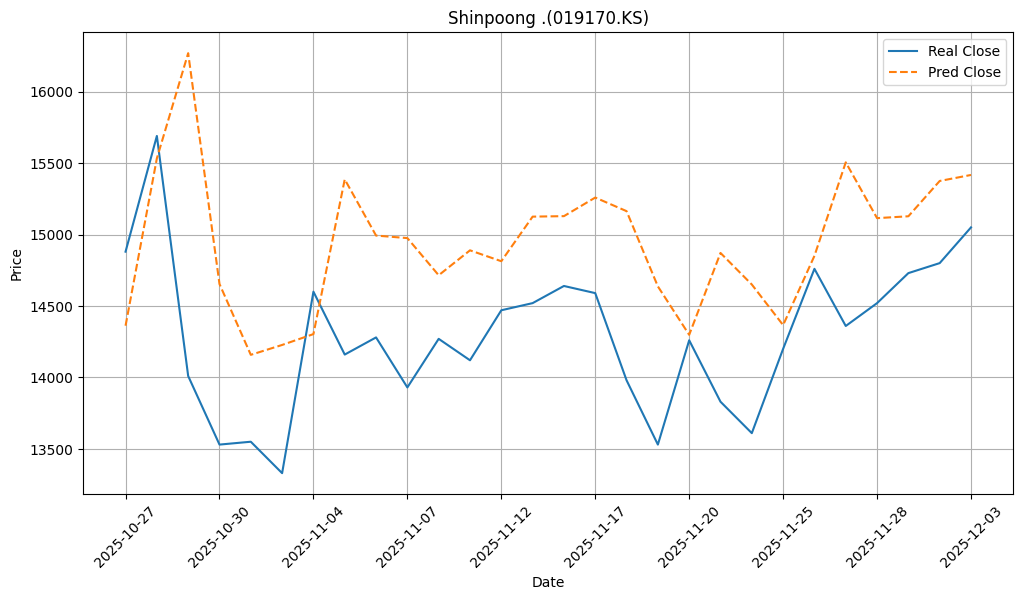

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


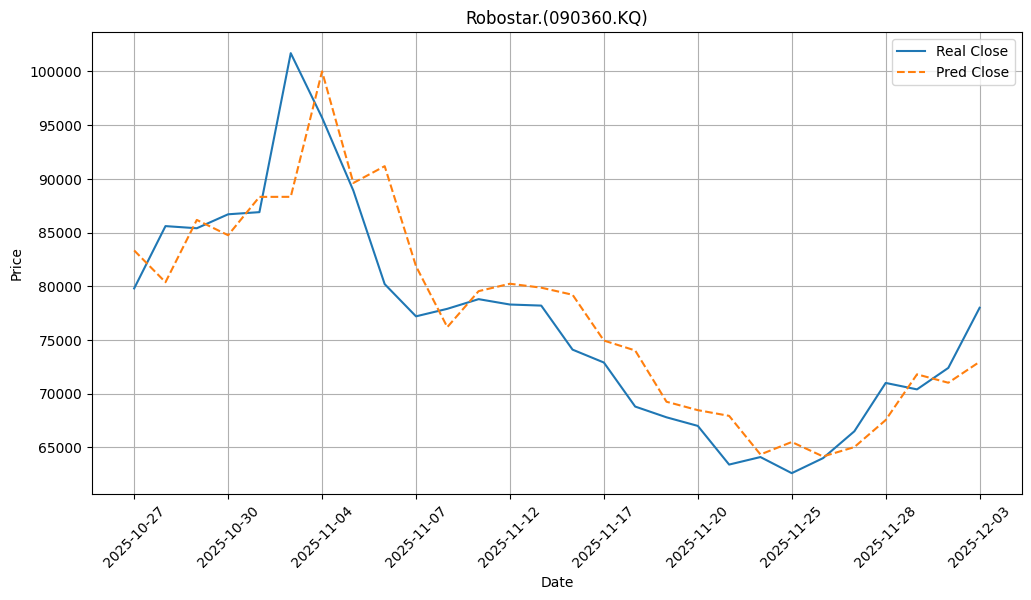

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


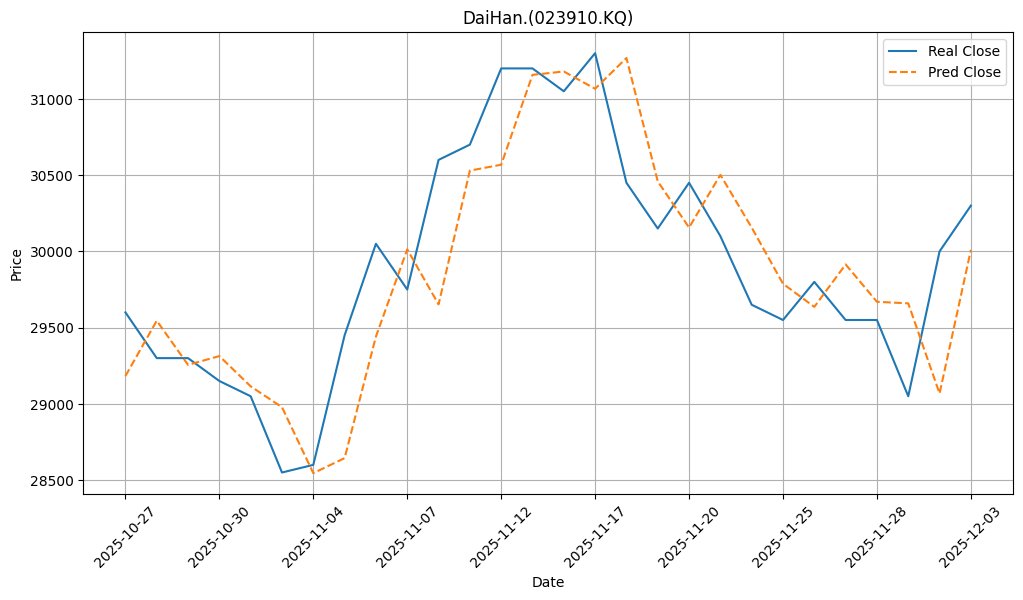

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


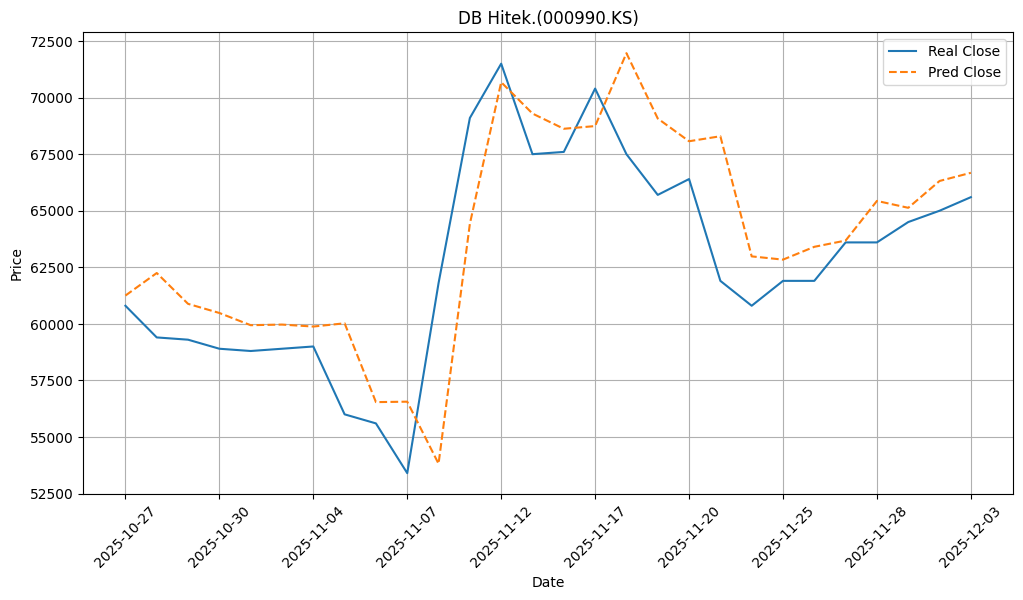

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


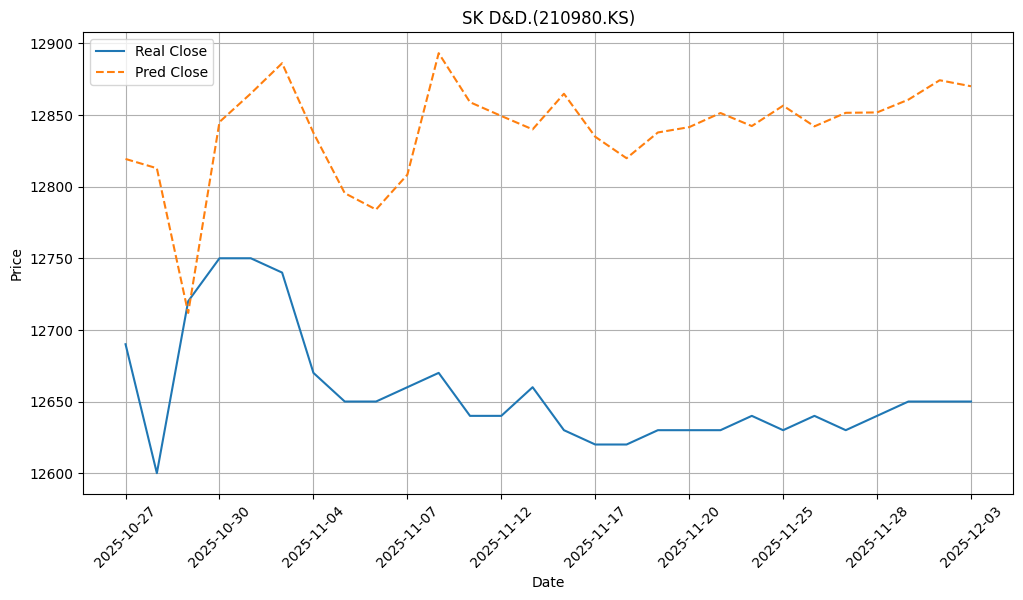

In [52]:
import matplotlib.pyplot as plt
from keras.models import load_model

def denormalize(y_norm, min_vals, max_vals,feature_indices=[0,1,2,3]):
    y = y_norm.copy()
    for i, idx in enumerate(feature_indices):
        y[:, i] = y[:, i] * (max_vals[idx] - min_vals[idx]) + min_vals[idx]
    return y

best_model=load_model("best_model.h5")


dates = shinpoong_pharm_finance.index[shinpoong_test_idx]
minmax_vals = [[sp_min,sp_max],[rbs_min,rbs_max],[dh_min,dh_max],[dbh_min,dbh_max],[skd_min,skd_max]]
titles = ["Shinpoong .(019170.KS)", "Robostar.(090360.KQ)", "DaiHan.(023910.KQ)","DB Hitek.(000990.KS)","SK D&D.(210980.KS)"]


for i, data in enumerate(np_test_list_norm):
    x_test_norm, y_true_norm = [], []
    for idx in range(data.shape[0] - lookback):
        x_test_norm.append(data[idx:idx+lookback])
        y_true_norm.append(data[idx+lookback,0:4])  # Close, Open, High, Low 등 4개

    x_test_norm = np.array(x_test_norm)
    y_true_norm = np.array(y_true_norm)

    # 예측
    y_pred_norm = best_model.predict(x_test_norm)

    # Figure 별로 생성
    plt.figure(figsize=(12,6))

    # 역정규화
    y_true = denormalize(y_true_norm, minmax_vals[i][0], minmax_vals[i][1])
    y_pred = denormalize(y_pred_norm, minmax_vals[i][0], minmax_vals[i][1])

    #show = ['Close','Open','High','Low']
    show = ['Close']
    for j, label in enumerate(show):
        plt.plot(y_true[:,j], label=f"Real {label}")
        plt.plot(y_pred[:,j], label=f"Pred {label}", linestyle='--')

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(titles[i])
    total_len=len(y_true)
    date_indices = np.arange(0, total_len, 3)
    plt.xticks(date_indices, [shinpoong_pharm_finance.index[shinpoong_test_idx][idx+lookback].strftime('%Y-%m-%d')
                              for idx in date_indices], rotation=45)
    plt.grid(True)
    plt.show()


In [45]:
#1일 예측만 하고 모델이 1일 shift한 것 처럼 나오고 있음 변경 사항으로  미래4일 예측 모델로 바꿔야 함 - 2025-12-04-01:34 AM

28 33
